In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile

In [ ]:

zip_path = "/content/drive/MyDrive/data.zip"
extract_to = "/content/data"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("Extraction completed.")


Extraction completed.


In [ ]:
!pip install segmentation-models-pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 40.2 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=b083a9d6910957800585aad78cf5b1d737596d72fc73c01c2677f82857c2b3c2
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=a5ba572935692dc29ddd4bc68f3ba4e2d694f8febafa88971b6d918570288e58
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch

In [ ]:
import torch.nn as nn
import torch.optim as optim
from  torch.utils.data import Dataset,DataLoader
import torch
import torchvision
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.collections import QuadMesh
import seaborn as sns
from tqdm import tqdm,trange
from time import sleep
import warnings
from glob import glob
import os,sys
import cv2
import segmentation_models_pytorch as smp

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
BASEPATH = '/content/data'

In [ ]:
def read_data(path):
    df=pd.read_csv(path,names=['image','label'],header=None)
    return df
def read_img(path):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

df = read_data(os.path.join(BASEPATH,'nyu2_train.csv'))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50688 entries, 0 to 50687
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   50688 non-null  object
 1   label   50688 non-null  object
dtypes: object(2)
memory usage: 792.1+ KB


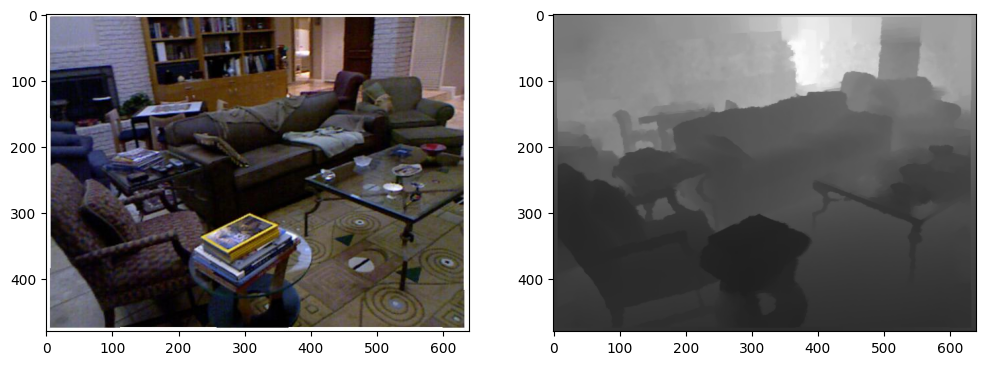

In [ ]:
fig,axis = plt.subplots(1,2,figsize=(12,6))
axis[0].imshow(read_img(df.iloc[0].image))
axis[1].imshow(read_img(df.iloc[0].label))
plt.show()

In [ ]:
class Config:
    img_size = (192, 256)

cfg = Config()

class NYU2_Dataset(Dataset):

    def __init__(self, df, transform=None, test=False):
        self.df = df
        self.transform = transform
        self.test = test

        self.data_id = df.index
        self.data = df.image.values
        self.labels = df.label.values

        self.label_trans = A.Compose([
            A.Resize(cfg.img_size[0], cfg.img_size[1], always_apply=True)
        ])

    def read_pair(self, idx):

        image_source = cv2.imread(self.data[idx])
        image_source = cv2.cvtColor(image_source, cv2.COLOR_BGR2RGB)

        image_label = cv2.imread(self.labels[idx], cv2.IMREAD_GRAYSCALE)

        return image_source, image_label

    def __getitem__(self, idx):

        id = self.data_id[idx]
        image_source, image_label = self.read_pair(idx)

        if self.transform:

            image_source = self.transform(image=image_source)['image']
            image_label = self.label_trans(image=image_label)['image']


            image_label = image_label.astype(np.float32) / 255.0
            image_label = torch.from_numpy(np.expand_dims(image_label, axis=0))

        return id, image_source, image_label

    def __len__(self):

        return len(self.data)

    def _working_test(self):

        test_loader = DataLoader(
            self,
            batch_size=1,
            shuffle=False,
            num_workers=1,
            drop_last=True,
            pin_memory=True
        )
        return next(iter(test_loader))

In [ ]:
def trans():

    label_trans = A.Compose([
        A.Resize(height=192, width=256, always_apply=True)
    ])

    trans_data = A.Compose([
        A.Resize(height=192, width=256, always_apply=True),
        A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
        ToTensorV2()
    ])

    return trans_data, label_trans

In [ ]:
trans_data, label_trans = trans()

nyu = NYU2_Dataset(
    df=df,
    transform=trans_data
)

loader = DataLoader(
    batch_size=32,
    dataset=nyu,
    num_workers=2,
    shuffle=True,
    pin_memory=True
)

# Resnet18

In [ ]:
model = smp.UnetPlusPlus(
    encoder_name="resnet18",
    encoder_weights=None,
    in_channels=3,
    classes=1,
    activation="sigmoid"
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

loss_function = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
from skimage.metrics import structural_similarity as ssim

epochs = 5

losses = []
mse = []
psnr = []
ssim = []

def mse_comp(predictions, targets):
    """Calculate Mean Squared Error (MSE)."""
    mse = ((predictions - targets) ** 2).mean()
    return mse.item()

def pnsr_comp(predictions, targets):
    """Calculate PSNR between predicted and target images."""
    predictions = np.clip(predictions * 255, 0, 255).astype(np.uint8)
    targets = np.clip(targets * 255, 0, 255).astype(np.uint8)

    mse = np.mean((predictions - targets) ** 2)
    if mse == 0:
        return 100
    max = 255.0
    psnr = 20 * np.log10(max / np.sqrt(mse))
    return psnr

for present_epoch in range(epochs):
    model.train()
    tot_los = 0
    tot_mse = 0
    tot_psnr = 0

    for idx, (data_id, input_image, img_target) in enumerate(loader):
        input_image = input_image.to(device)
        img_target = img_target.to(device)

        predictions = model(input_image)
        los_batch = loss_function(predictions, img_target)

        batch_mse = mse_comp(predictions, img_target)
        batch_psnr = pnsr_comp(predictions.cpu().detach().numpy(), img_target.cpu().detach().numpy())

        tot_los += los_batch.item()
        tot_mse += batch_mse
        tot_psnr += batch_psnr

        optimizer.zero_grad()
        los_batch.backward()
        optimizer.step()

        print(
            f"Epoch [{present_epoch + 1}/{epochs}], "
            f"Batch [{idx + 1}/{len(loader)}], "
            f"Loss: {los_batch.item():.4f}, "
            f"MSE: {batch_mse:.4f}, "
            f"PSNR: {batch_psnr:.4f}, "
        )

    los_avg = tot_los / len(loader)
    mse_avg = tot_mse / len(loader)
    psnr_avg = tot_psnr / len(loader)

    losses.append(los_avg)
    mse.append(mse_avg)
    psnr.append(psnr_avg)

    print(
        f"Epoch [{present_epoch + 1}/{epochs}], "
        f"Average Loss: {los_avg:.4f}, "
        f"Average MSE: {mse_avg:.4f}, "
        f"Average PSNR: {psnr_avg:.4f}, "
    )


Streaming output truncated to the last 5000 lines.
Epoch [2/5], Batch [1341/1584], Loss: 0.5585, MSE: 0.0023, PSNR: 30.4558, 
Epoch [2/5], Batch [1342/1584], Loss: 0.5396, MSE: 0.0033, PSNR: 29.2482, 
Epoch [2/5], Batch [1343/1584], Loss: 0.5373, MSE: 0.0080, PSNR: 28.4602, 
Epoch [2/5], Batch [1344/1584], Loss: 0.5736, MSE: 0.0023, PSNR: 30.5837, 
Epoch [2/5], Batch [1345/1584], Loss: 0.5385, MSE: 0.0025, PSNR: 30.5251, 
Epoch [2/5], Batch [1346/1584], Loss: 0.5636, MSE: 0.0025, PSNR: 30.8631, 
Epoch [2/5], Batch [1347/1584], Loss: 0.5608, MSE: 0.0026, PSNR: 30.4583, 
Epoch [2/5], Batch [1348/1584], Loss: 0.5661, MSE: 0.0024, PSNR: 30.5243, 
Epoch [2/5], Batch [1349/1584], Loss: 0.5480, MSE: 0.0031, PSNR: 30.2774, 
Epoch [2/5], Batch [1350/1584], Loss: 0.5470, MSE: 0.0019, PSNR: 30.9127, 
Epoch [2/5], Batch [1351/1584], Loss: 0.5329, MSE: 0.0018, PSNR: 30.8048, 
Epoch [2/5], Batch [1352/1584], Loss: 0.5450, MSE: 0.0029, PSNR: 30.6140, 
Epoch [2/5], Batch [1353/1584], Loss: 0.5489, MSE

In [ ]:
torch.save(model.state_dict(), "Resnet18.pth")

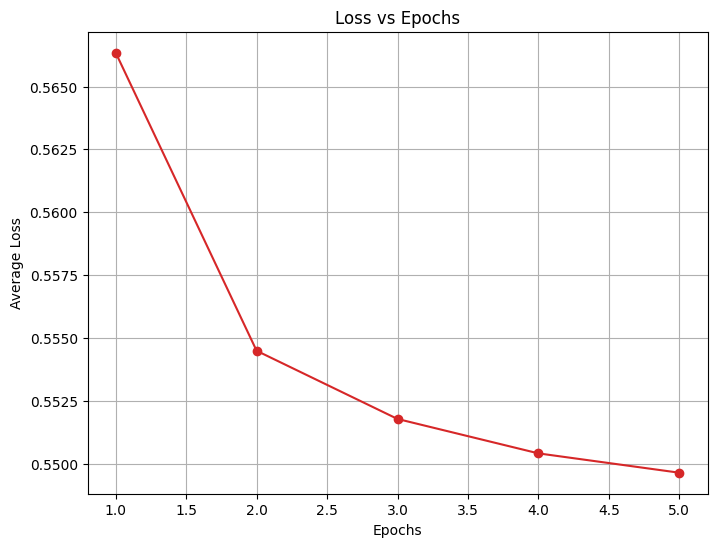

In [ ]:
# Plot Loss
plt.figure(figsize=(8, 6))
plt.plot(range(1, epochs + 1), losses, marker='o', color='tab:red')
plt.xlabel('Epochs')
plt.ylabel('Average Loss')
plt.title('Loss vs Epochs')
plt.grid(True)
plt.show()


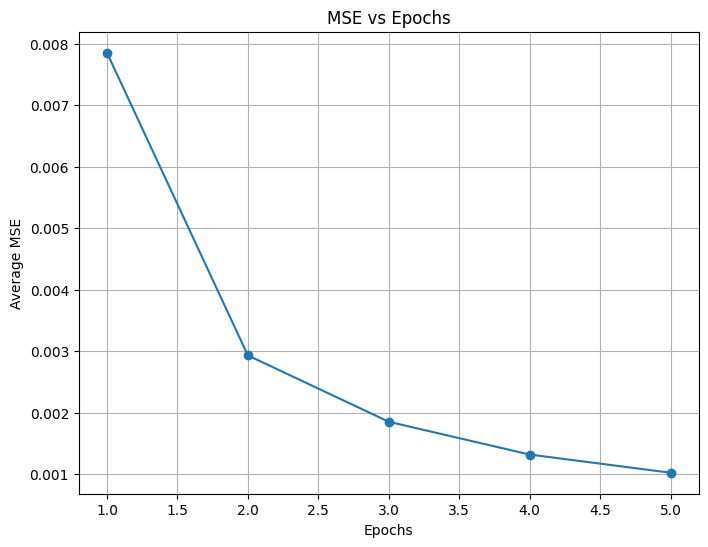

In [ ]:
# Plot MSE
plt.figure(figsize=(8, 6))
plt.plot(range(1, epochs + 1), mse, marker='o', color='tab:blue')
plt.xlabel('Epochs')
plt.ylabel('Average MSE')
plt.title('MSE vs Epochs')
plt.grid(True)
plt.show()

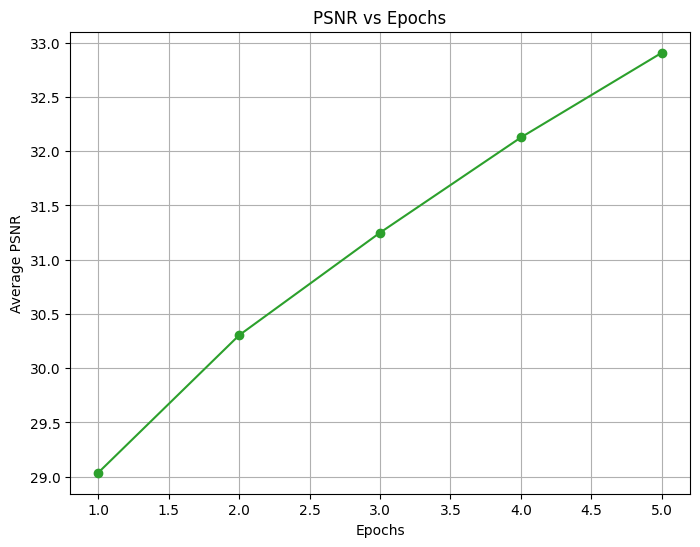

In [ ]:
# Plot PSNR
plt.figure(figsize=(8, 6))
plt.plot(range(1, epochs + 1), psnr, marker='o', color='tab:green')
plt.xlabel('Epochs')
plt.ylabel('Average PSNR')
plt.title('PSNR vs Epochs')
plt.grid(True)
plt.show()

In [ ]:
model.load_state_dict(
    torch.load("Resnet18.pth", map_location=torch.device("cpu"))
)

<ipython-input-35-7f4ecc51e96e>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load("unetplusplus_weights.pth", map_location=torch.device("cpu"))


<All keys matched successfully>

In [ ]:
model.eval()

print('Avoiding Display')

Avoiding Display


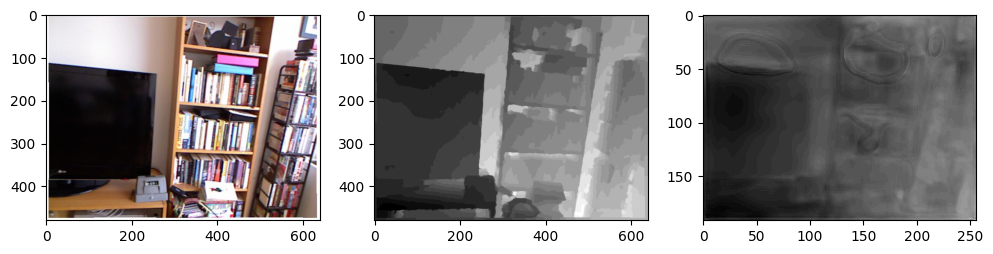

In [ ]:
def load_img(path, label=False):
    image = cv2.imread(path)
    if label:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    image = cv2.resize(
        image.astype("uint8"),
        (640, 480),
        interpolation=cv2.INTER_AREA
    )
    return image

def trans_img(path):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    transformed = trans_data(image=image)['image']
    return transformed[None, ...]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def pred_img(path, norm=True):
    input_image = trans_img(path).to(device)

    bas = model(input_image).cpu().detach()[0]
    prediction = np.transpose(np.array(bas), (1, 2, 0))
    prediction = np.clip((prediction * 255).astype(int), 0, 255)

    if norm:
        prediction = (prediction - prediction.min()) * (255 / prediction.max())

    return prediction

def preview_img(idx):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    axes[0].imshow(load_img(df.iloc[idx].image))

    axes[1].imshow(load_img(df.iloc[idx].label, label=True), cmap='gray')

    axes[2].imshow(pred_img(df.iloc[idx].image), cmap='gray')

    plt.show()

preview_img(15000)

# Resnet50

In [ ]:
model = smp.UnetPlusPlus(
    encoder_name="resnet50",
    encoder_weights=None,
    in_channels=3,
    classes=1,
    activation="sigmoid"
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

loss_function = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
from skimage.metrics import structural_similarity as ssim

epochs = 10

losses = []
mse = []
psnr = []
ssim = []

def mse_comp(predictions, targets):
    mse = ((predictions - targets) ** 2).mean()
    return mse.item()

def pnsr_comp(predictions, targets):
    predictions = np.clip(predictions * 255, 0, 255).astype(np.uint8)
    targets = np.clip(targets * 255, 0, 255).astype(np.uint8)

    mse = np.mean((predictions - targets) ** 2)
    if mse == 0:
        return 100
    max = 255.0
    psnr = 20 * np.log10(max / np.sqrt(mse))
    return psnr

for present_epoch in range(epochs):
    model.train()
    tot_los = 0
    tot_mse = 0
    tot_psnr = 0

    for idx, (data_id, input_image, img_target) in enumerate(loader):
        input_image = input_image.to(device)
        img_target = img_target.to(device)

        predictions = model(input_image)
        los_batch = loss_function(predictions, img_target)

        batch_mse = mse_comp(predictions, img_target)
        batch_psnr = pnsr_comp(predictions.cpu().detach().numpy(), img_target.cpu().detach().numpy())

        tot_los += los_batch.item()
        tot_mse += batch_mse
        tot_psnr += batch_psnr

        optimizer.zero_grad()
        los_batch.backward()
        optimizer.step()

        print(
            f"Epoch [{present_epoch + 1}/{epochs}], "
            f"Batch [{idx + 1}/{len(loader)}], "
            f"Loss: {los_batch.item():.4f}, "
            f"MSE: {batch_mse:.4f}, "
            f"PSNR: {batch_psnr:.4f}, "
        )

    los_avg = tot_los / len(loader)
    mse_avg = tot_mse / len(loader)
    psnr_avg = tot_psnr / len(loader)

    losses.append(los_avg)
    mse.append(mse_avg)
    psnr.append(psnr_avg)

    print(
        f"Epoch [{present_epoch + 1}/{epochs}], "
        f"Average Loss: {los_avg:.4f}, "
        f"Average MSE: {mse_avg:.4f}, "
        f"Average PSNR: {psnr_avg:.4f}, "
    )


Streaming output truncated to the last 5000 lines.
Epoch [7/10], Batch [1341/1584], Loss: 0.5433, MSE: 0.0008, PSNR: 33.4896, 
Epoch [7/10], Batch [1342/1584], Loss: 0.5519, MSE: 0.0007, PSNR: 33.9588, 
Epoch [7/10], Batch [1343/1584], Loss: 0.5496, MSE: 0.0009, PSNR: 33.0479, 
Epoch [7/10], Batch [1344/1584], Loss: 0.5368, MSE: 0.0008, PSNR: 33.3769, 
Epoch [7/10], Batch [1345/1584], Loss: 0.5473, MSE: 0.0007, PSNR: 33.9621, 
Epoch [7/10], Batch [1346/1584], Loss: 0.5597, MSE: 0.0010, PSNR: 32.9096, 
Epoch [7/10], Batch [1347/1584], Loss: 0.5574, MSE: 0.0010, PSNR: 33.7017, 
Epoch [7/10], Batch [1348/1584], Loss: 0.5475, MSE: 0.0010, PSNR: 33.7648, 
Epoch [7/10], Batch [1349/1584], Loss: 0.5440, MSE: 0.0007, PSNR: 33.9861, 
Epoch [7/10], Batch [1350/1584], Loss: 0.5500, MSE: 0.0009, PSNR: 33.5194, 
Epoch [7/10], Batch [1351/1584], Loss: 0.5322, MSE: 0.0009, PSNR: 33.5999, 
Epoch [7/10], Batch [1352/1584], Loss: 0.5566, MSE: 0.0006, PSNR: 33.9218, 
Epoch [7/10], Batch [1353/1584], Loss

In [ ]:
torch.save(model.state_dict(), "Resnet50.pth")

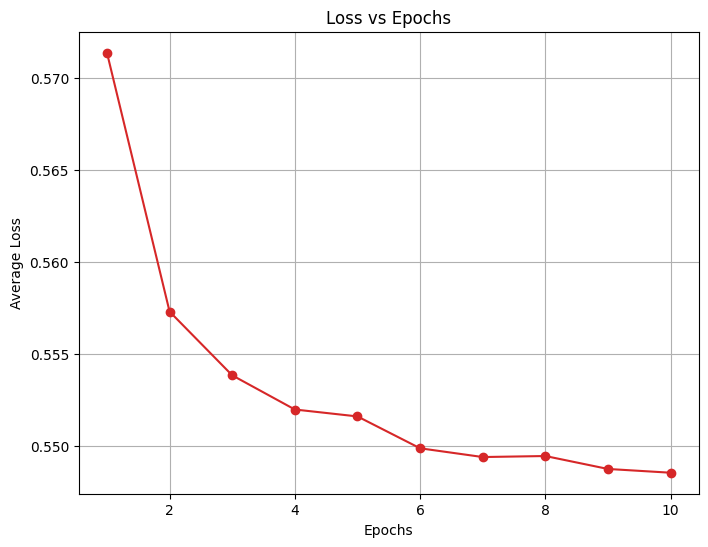

In [ ]:
# Plot Loss
plt.figure(figsize=(8, 6))
plt.plot(range(1, epochs + 1), losses, marker='o', color='tab:red')
plt.xlabel('Epochs')
plt.ylabel('Average Loss')
plt.title('Loss vs Epochs')
plt.grid(True)
plt.show()


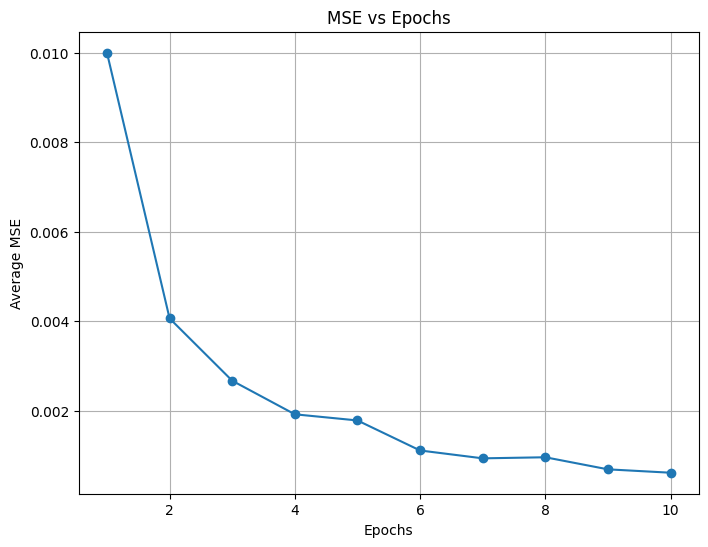

In [ ]:
# Plot MSE
plt.figure(figsize=(8, 6))
plt.plot(range(1, epochs + 1), mse, marker='o', color='tab:blue')
plt.xlabel('Epochs')
plt.ylabel('Average MSE')
plt.title('MSE vs Epochs')
plt.grid(True)
plt.show()

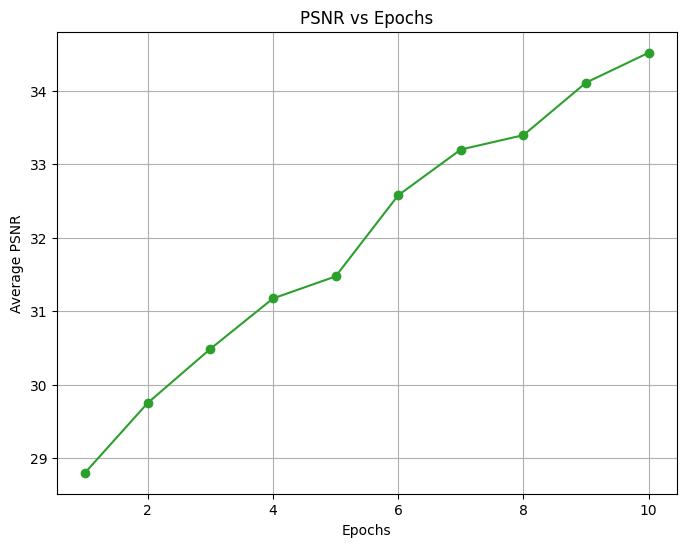

In [ ]:
# Plot PSNR
plt.figure(figsize=(8, 6))
plt.plot(range(1, epochs + 1), psnr, marker='o', color='tab:green')
plt.xlabel('Epochs')
plt.ylabel('Average PSNR')
plt.title('PSNR vs Epochs')
plt.grid(True)
plt.show()

In [ ]:
model.load_state_dict(
    torch.load("Resnet50.pth", map_location=torch.device("cpu"))
)

<ipython-input-26-1f8bd47eb320>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load("Resnet50.pth", map_location=torch.device("cpu"))


<All keys matched successfully>

In [ ]:
model.eval()

print('Avoiding Display')

Avoiding Display


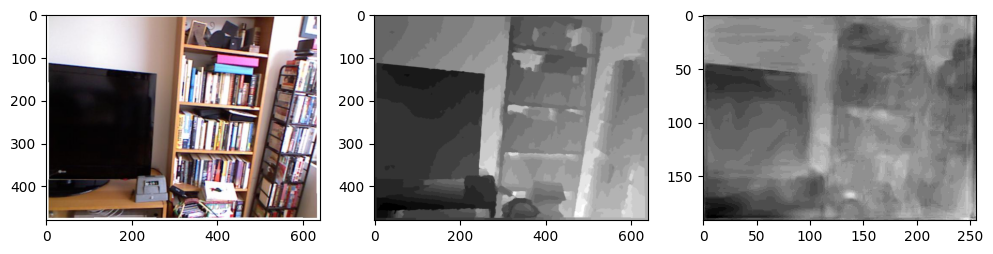

In [ ]:
def load_img(path, label=False):
    image = cv2.imread(path)
    if label:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    image = cv2.resize(
        image.astype("uint8"),
        (640, 480),
        interpolation=cv2.INTER_AREA
    )
    return image

def trans_img(path):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    transformed = trans_data(image=image)['image']
    return transformed[None, ...]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def pred_img(path, norm=True):
    input_image = trans_img(path).to(device)

    bas = model(input_image).cpu().detach()[0]
    prediction = np.transpose(np.array(bas), (1, 2, 0))
    prediction = np.clip((prediction * 255).astype(int), 0, 255)

    if norm:
        prediction = (prediction - prediction.min()) * (255 / prediction.max())

    return prediction

def preview_img(idx):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    axes[0].imshow(load_img(df.iloc[idx].image))

    axes[1].imshow(load_img(df.iloc[idx].label, label=True), cmap='gray')

    axes[2].imshow(pred_img(df.iloc[idx].image), cmap='gray')

    plt.show()

preview_img(15000)

In [ ]:
def pred_image_resize(image, target_size=(640, 480)):
    resized_image = cv2.resize(
        image.astype("uint8"),
        (target_size[0], target_size[1]),
        interpolation=cv2.INTER_AREA
    )
    return resized_image


# Unseen Prediction

In [ ]:
from sklearn.cluster import KMeans,DBSCAN
from sklearn.mixture import GaussianMixture

In [ ]:
k=6
id_img=15000

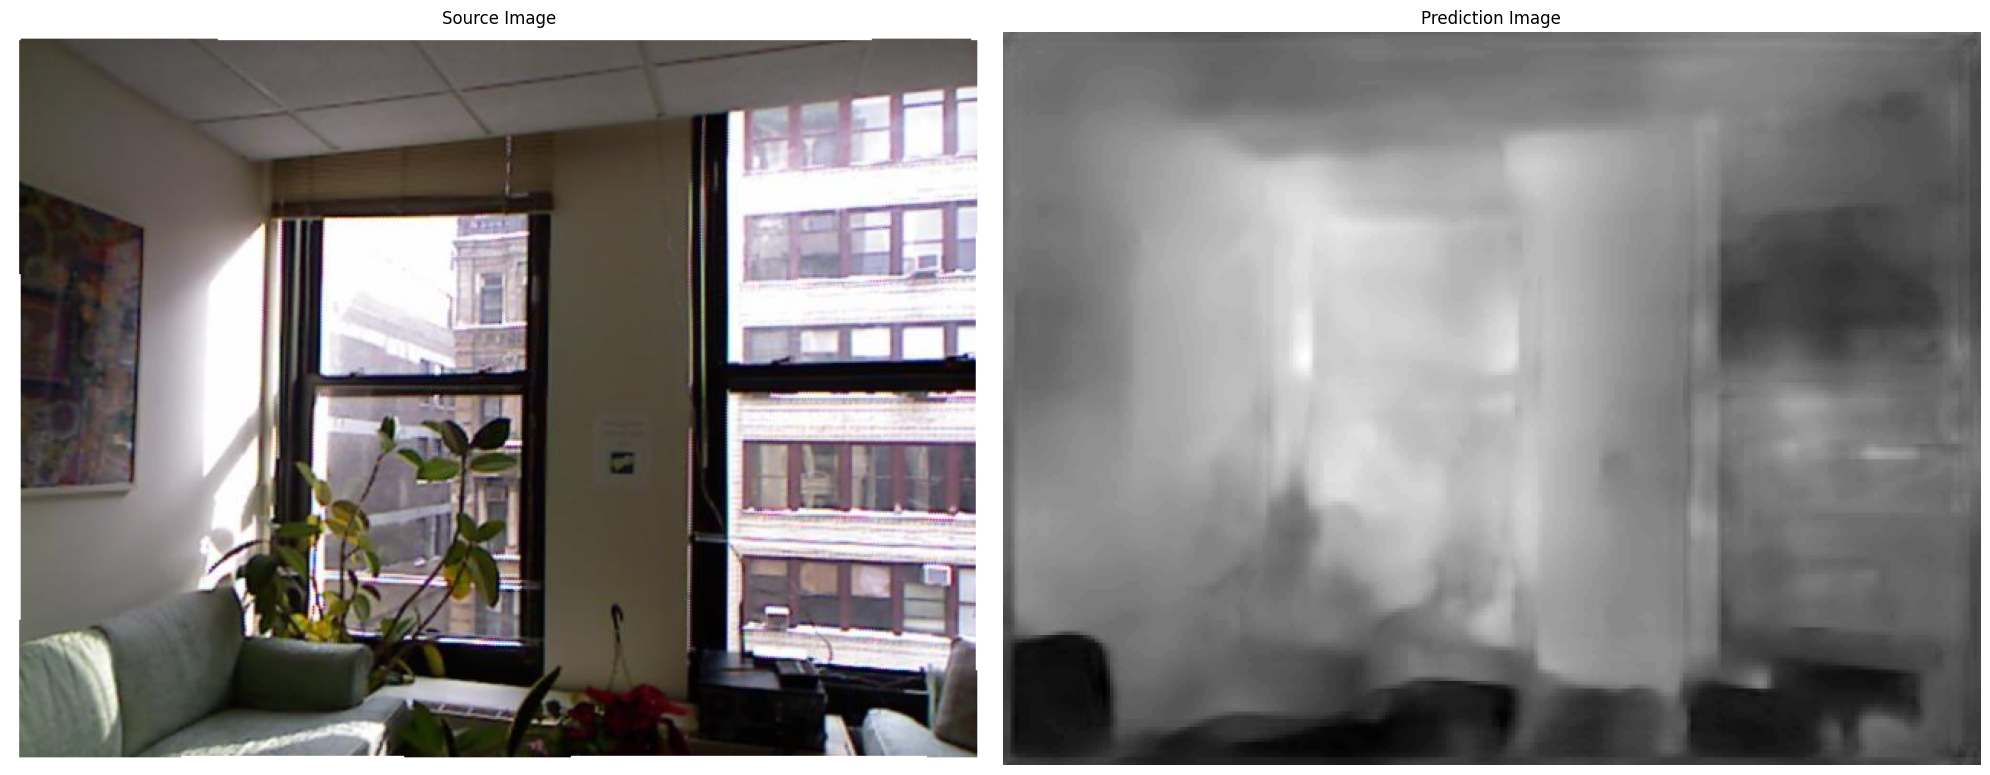

In [ ]:
img_pat = '/content/data/nyu2_test/00013_colors.png'

input_image = load_img(img_pat)
predicted_img = pred_img(img_pat)
resized_pred = pred_image_resize(predicted_img)

figure, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

axes[0].imshow(input_image)
axes[0].set_title("Source Image")
axes[0].axis("off")

axes[1].imshow(resized_pred, cmap="gray")
axes[1].set_title("Prediction Image")
axes[1].axis("off")

plt.tight_layout()
plt.show()

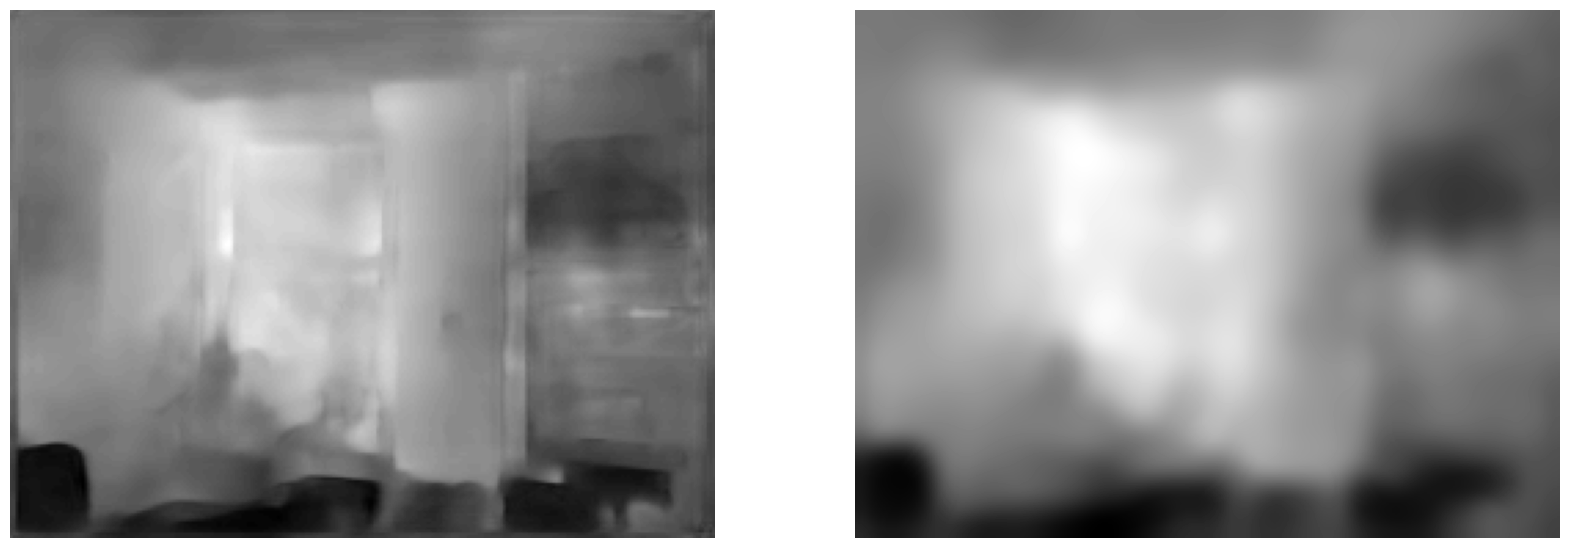

In [ ]:
def extract_clust(image):
    flat = image.reshape(-1)
    features = []

    for idx, pix_val in enumerate(flat):
        norm_val = pix_val / 255
        features.append([norm_val])

    feat_arr = np.array(features)
    return feat_arr

feat_pred = extract_clust(predicted_img)

smooth_enhanc = cv2.medianBlur(predicted_img.astype("float32"), 5)
for _ in range(3):
    smooth_enhanc = cv2.medianBlur(smooth_enhanc.astype("float32"), 5)

size_kernel = [(15, 15), (13, 13), (11, 11), (9, 9)]
for kernel_size in size_kernel:
    smooth_enhanc = cv2.GaussianBlur(smooth_enhanc, kernel_size, 0)

for _ in range(3):
    smooth_enhanc = cv2.medianBlur(smooth_enhanc.astype("float32"), 5)

feat_smooth = extract_clust(smooth_enhanc)

fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(predicted_img, cmap="gray")
axes[1].imshow(smooth_enhanc, cmap="gray")

for ax in axes:
    ax.axis("off")

plt.show()

In [ ]:
if predicted_img.shape[:2] != (480, 640):
    print("Resizing predicted_img to match expected dimensions (480, 640).")
    predicted_img = cv2.resize(predicted_img, (640, 480), interpolation=cv2.INTER_AREA)

feat_pred = extract_clust(predicted_img)
print(f"Shape of feat_pred: {feat_pred.shape}")

if smooth_enhanc.shape[:2] != (480, 640):
    print("Resizing smooth_enhanc to match expected dimensions (480, 640).")
    smooth_enhanc = cv2.resize(smooth_enhanc, (640, 480), interpolation=cv2.INTER_AREA)

feat_smooth = extract_clust(smooth_enhanc)
print(f"Shape of feat_smooth: {feat_smooth.shape}")

img_class = (
    KMeans(n_clusters=k, random_state=31)
    .fit(feat_pred)
    .labels_.reshape(480, 640)
)

blur_class = (
    KMeans(n_clusters=k, random_state=31)
    .fit(feat_smooth)
    .labels_.reshape(480, 640)
)

Resizing predicted_img to match expected dimensions (480, 640).
Shape of feat_pred: (307200, 1)
Resizing smooth_enhanc to match expected dimensions (480, 640).
Shape of feat_smooth: (307200, 1)


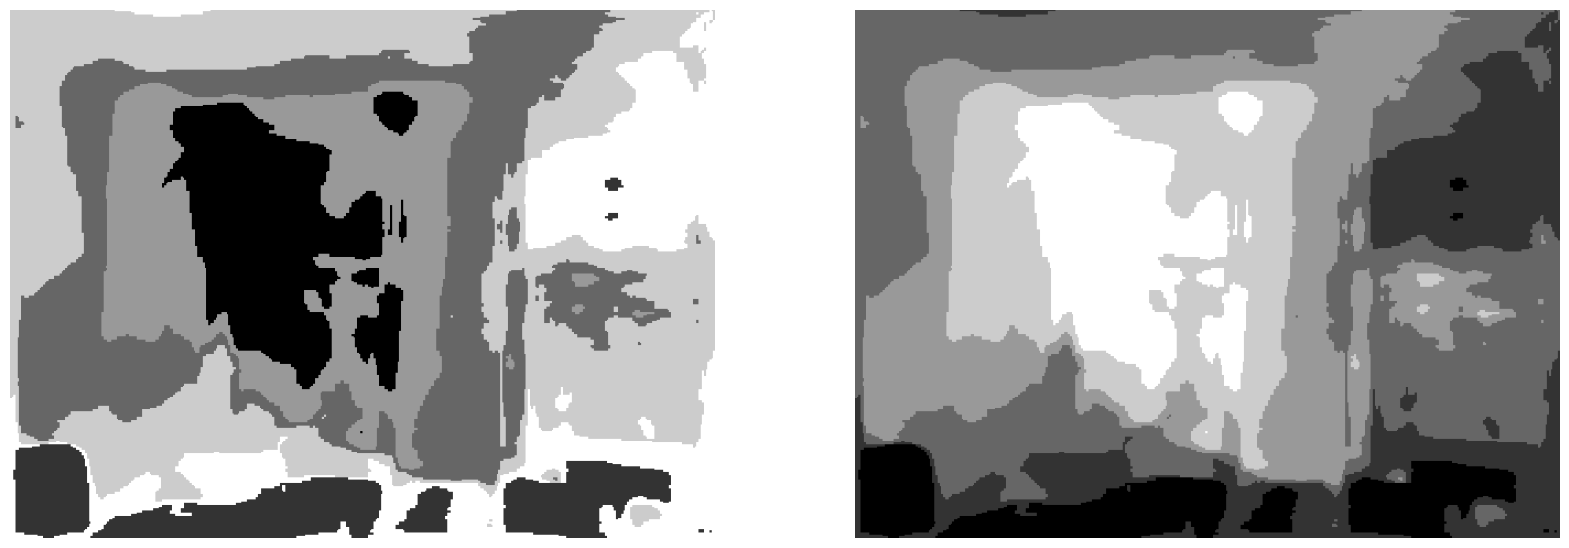

In [ ]:
def kmeans_classes(pred_image, img_class, k):
    img_class = img_class.astype(np.int8)
    class_sum = []

    for cluster in range(k):
        mask = (img_class == cluster)
        size_clus = mask.sum()
        mean_clus = (pred_image * mask).sum() / size_clus
        class_sum.append([cluster, mean_clus])

    s_df = pd.DataFrame(
        data=class_sum,
        columns=["label", "mean_value"]
    ).sort_values(by="mean_value", ascending=False).reset_index(drop=True)

    s_df["label"] = s_df["label"].astype(np.int8)

    reordered = np.zeros_like(img_class, dtype=np.int8)
    for labeled_new in range(k):
        labeled_origi = int(s_df.iloc[labeled_new].label)
        reordered += ((img_class == labeled_origi) | (reordered > 0)).astype(np.int8)

    reordered -= 1
    return reordered

classes_newly = kmeans_classes(predicted_img, img_class, k)
blur_classes_newly = kmeans_classes(predicted_img, blur_class, k)

fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(img_class, cmap="gray")
axes[1].imshow(classes_newly, cmap="gray")

for ax in axes:
    ax.axis("off")

plt.show()

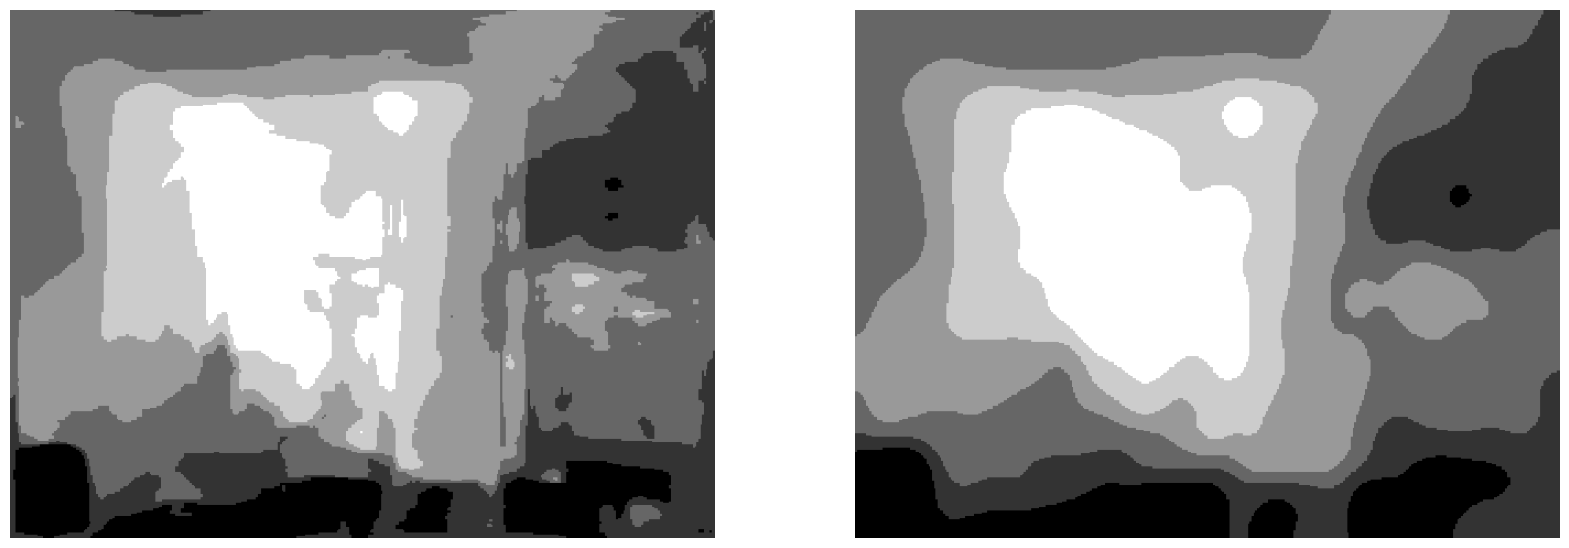

In [ ]:
figure, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

axes[0].imshow(classes_newly, cmap="gray")
axes[1].imshow(blur_classes_newly, cmap="gray")

for ax in axes:
    ax.axis("off")

plt.show()

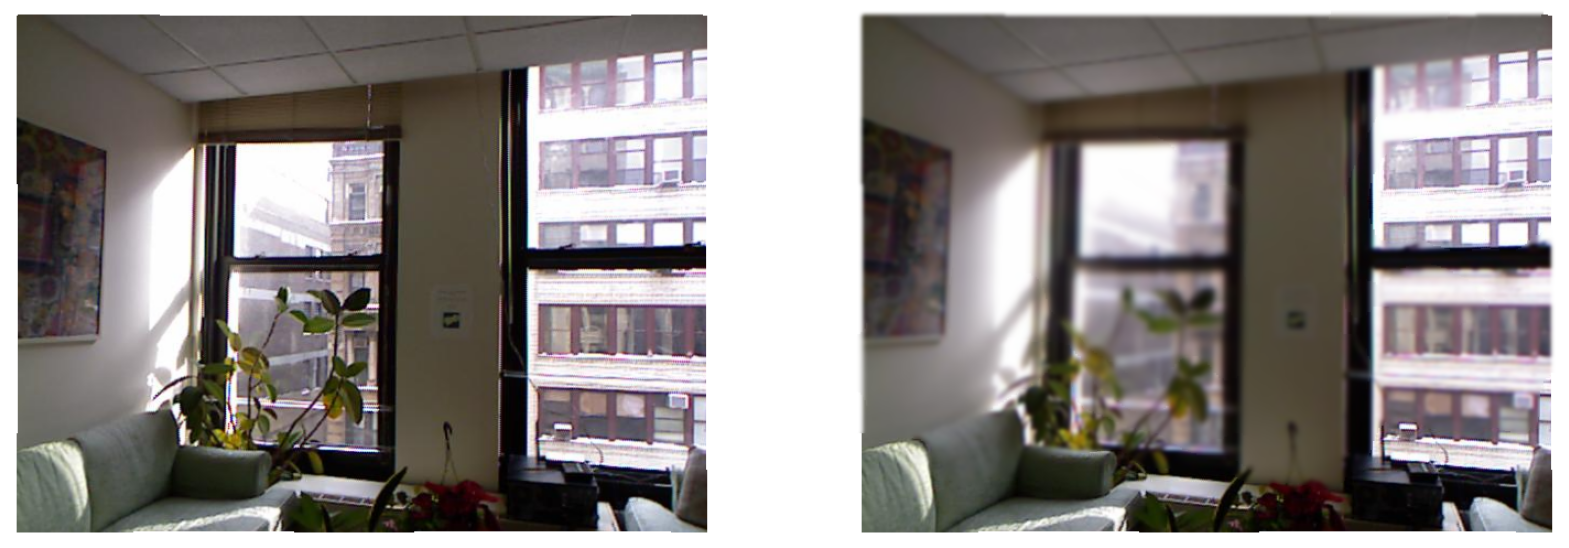

In [ ]:
def focused_img(input_image, mask_class, k, max_size=101):
    focused = np.zeros_like(input_image)

    for class_idx in range(k):
        blurred_img = input_image.copy()
        present_mask = (mask_class.astype(int) == class_idx)[..., None]

        blurred_size = int((class_idx / (k - 1)) * max_size)
        blurred_size += 1 if blurred_size % 2 == 0 else 0

        if class_idx != 0 and blurred_size > 5:
            if blurred_size >= 13 and False:
                blurred_img = cv2.blur(input_image, (blurred_size, blurred_size))
            else:
                blurred_img = cv2.GaussianBlur(input_image, (blurred_size, blurred_size), 0)

        blur_mask = blurred_img * present_mask
        focused += blur_mask

    return focused.astype(int)

img_focus = focused_img(input_image, blur_classes_newly, k, max_size=21)

fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(input_image)
axes[1].imshow(img_focus)

for ax in axes:
    ax.axis("off")

plt.show()

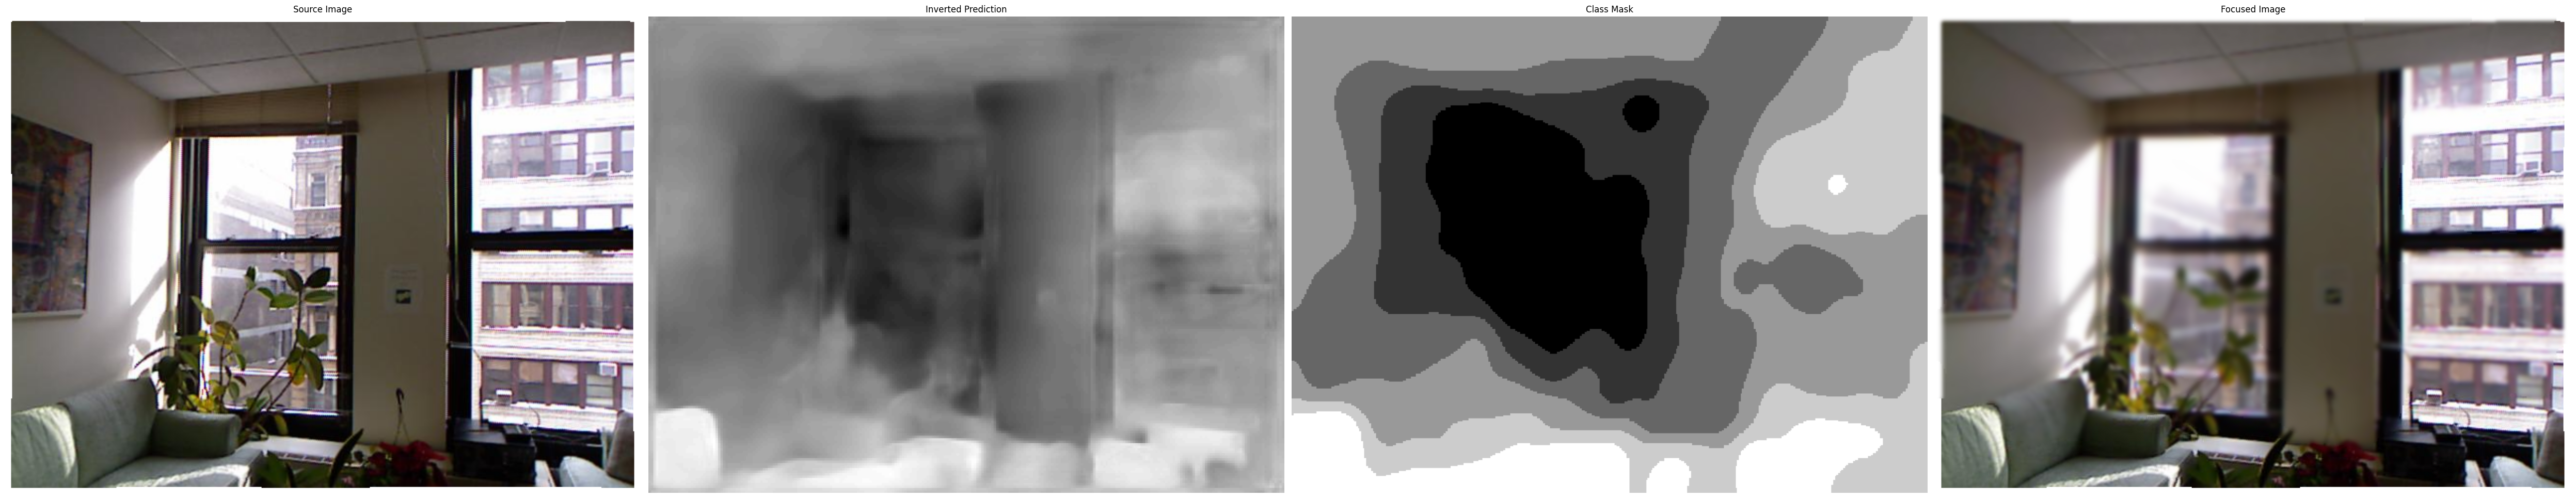

In [ ]:
mask_class = 1 - (blur_classes_newly / (k - 1))

figure, axes = plt.subplots(nrows=1, ncols=4, figsize=(50, 20))

axes[0].imshow(input_image)
axes[0].set_title("Source Image")

axes[1].imshow((255 - predicted_img), cmap="gray")
axes[1].set_title("Inverted Prediction")

axes[2].imshow(mask_class, cmap="gray", vmin=0, vmax=1)
axes[2].set_title("Class Mask")

axes[3].imshow(img_focus)
axes[3].set_title("Focused Image")

for ax in axes:
    ax.axis("off")

plt.tight_layout()
plt.show()